# < MNIST by RNN >

## - MNIST & Structure of RNN

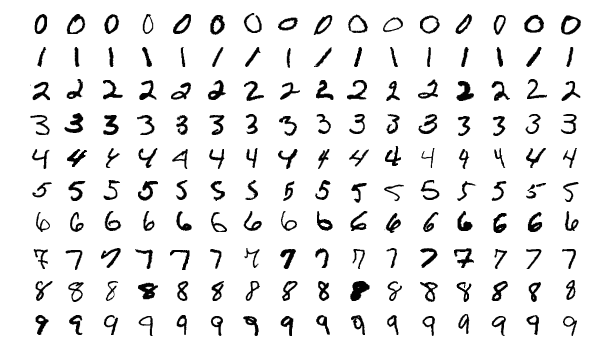

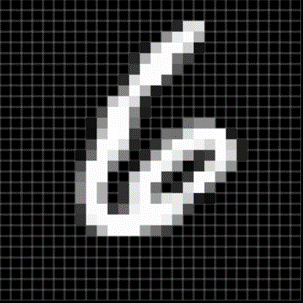

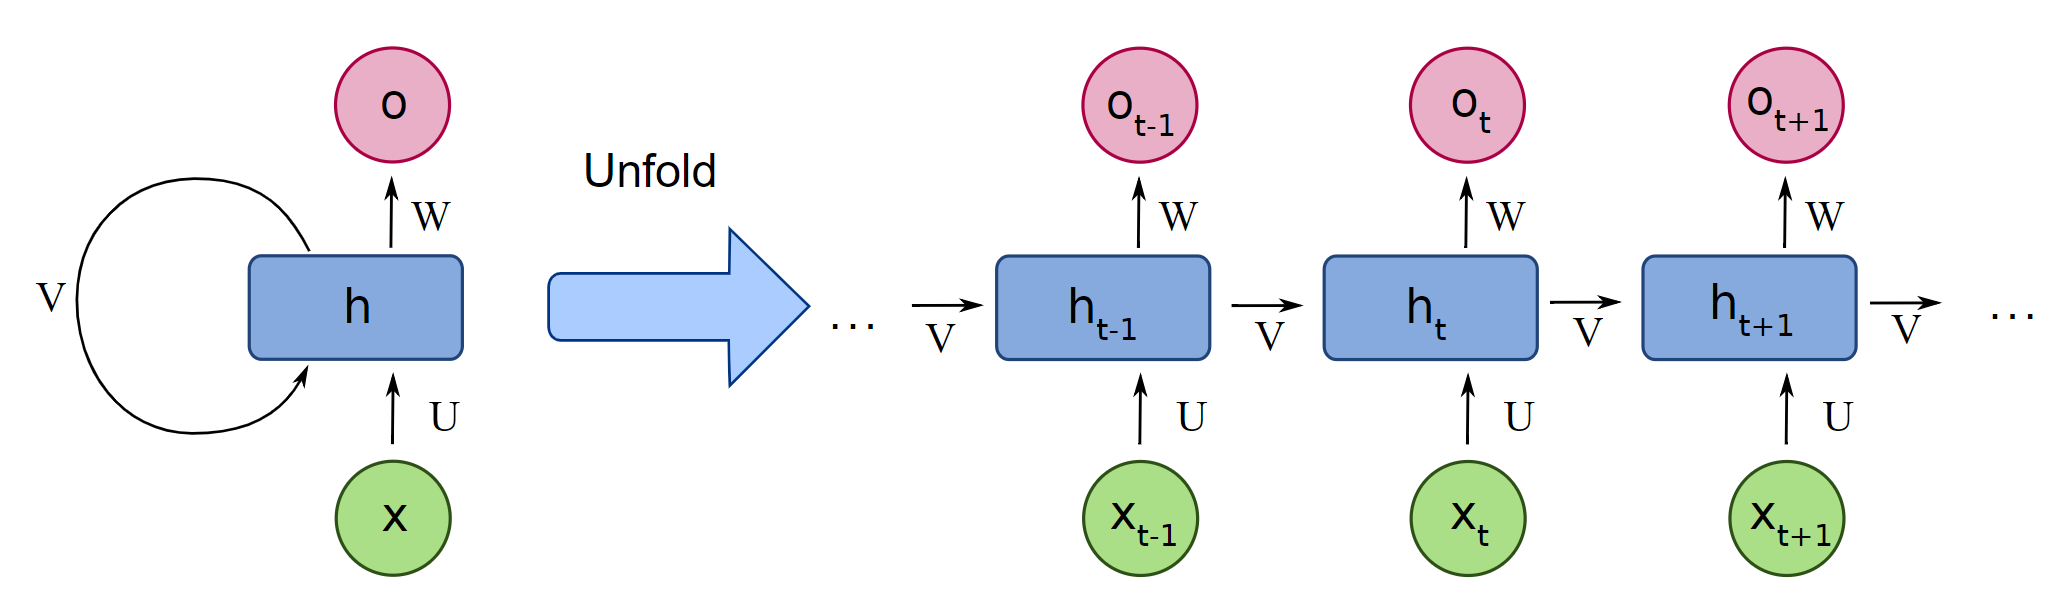

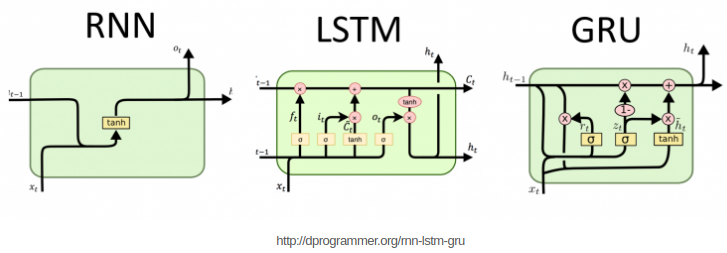

## - Import libraries

In [57]:
import torch
import torchvision
from torchvision import transforms, datasets, utils
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary

import numpy as np

## - Set GPU Environment

In [58]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

## - Set Hyper-parameters
  

In [70]:
seq_len    = 28
input_dim  = 28
hidden_dim = 64

no_class   = 10

BATCH_SIZE = 256
EPOCHS     = 5

LR         = 0.001

## - Prepare the DataSet

https://en.wikipedia.org/wiki/MNIST_database

### - Calculate Mean and Std

In [60]:
train_MNIST_raw = datasets.MNIST(root='./dataset/mnist', train=True, download=True, transform=transforms.ToTensor())
imgs = [item[0] for item in train_MNIST_raw] # item[0] and item[1] are image and its label
imgs = torch.stack(imgs, dim=0).numpy()
print(imgs.shape)

# calculate mean over each channel (r,g,b)
mean = imgs[:,0].mean()
print(mean)

# calculate std over each channel (r,g,b)
std = imgs[:].std()
print(std)

# calculate mean_std over each channel std (r,g,b)
std_all = np.array([np.std(x, axis=(1,2)) for x in imgs])
std = std_all[:,0].mean()
print(std)


(60000, 1, 28, 28)
0.13066062
0.30810776
0.3013119


### - DataLoader for Train / Test

In [61]:
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307), std=(0.3013))
])

trainset = torchvision.datasets.MNIST(root='./dataset/mnist', train=True, download=True, transform=transform_MNIST)
testset = torchvision.datasets.MNIST(root='./dataset/mnist', train=False, transform=transform_MNIST)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory = True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory = True,
    num_workers=4
)

## - Make a Model

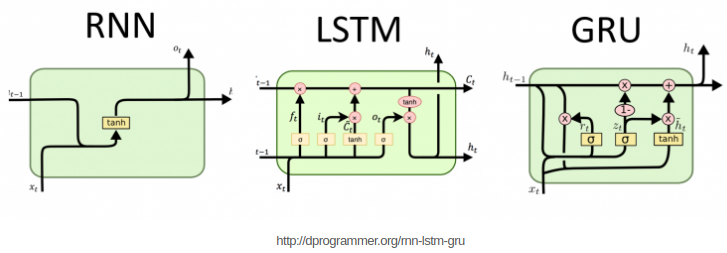

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

In [89]:
class ImageRNN(torch.nn.Module):
    def __init__(self, batch_size, seq_length, input_size, hidden_size, num_classes):
        super().__init__()
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        # make rnn
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        # make fully-connected
        self.fc = torch.nn.Linear(seq_length*hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, self.seq_length, self.input_size)            # (-1, 28, 28)

        x, hidden = self.rnn(x)                                     # (-1, 28, 64)  (1, BatchSize, 64)

        x = x.reshape(-1, (self.seq_length * self.hidden_size))     # (-1, 1792)
        out = self.fc(x)
        return out

In [90]:
model     = ImageRNN(BATCH_SIZE, seq_len, input_dim, hidden_dim, no_class).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 28, 64], [-1, 2, 64]]               0
            Linear-2                   [-1, 10]          17,930
Total params: 17,930
Trainable params: 17,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.75
Params size (MB): 0.07
Estimated Total Size (MB): 1.82
----------------------------------------------------------------


In [91]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 40 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [92]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## - Train the Model

In [93]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331378
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.416816
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.259115
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.268328
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.244660
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.313062
[1] Test Loss: 0.2125, Accuracy: 93.53%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.245468
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.213677
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.121126
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.194882
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.211579
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.126304
[2] Test Loss: 0.1356, Accuracy: 95.83%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.121965
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.185657
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.129370
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.114537
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.118464
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.112511
[3] Test Loss: 0.0931, Accuracy: 97